In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# make the original data
series = np.sin((0.1*np.arange(400))**2)

This is a time series of the form:
    \begin{align}
        x_t = sin(wt^2)\\
    \end{align}

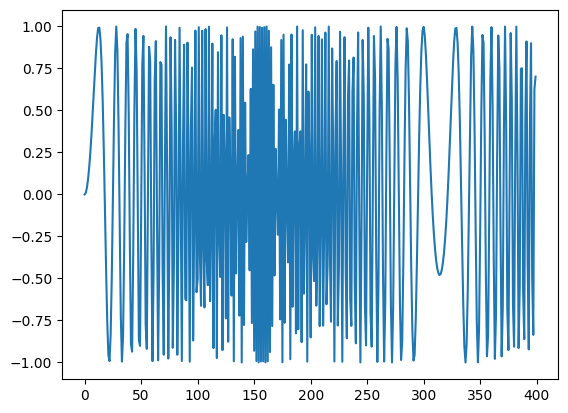

In [ ]:
# plot it
plt.plot(series)
plt.show()

In [ ]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T) # make it N x T
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (390, 10) Y.shape (390,)


In [ ]:
### try autoregressive linear model
i = Input(shape=(T,))
x = Dense(1)(i)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(learning_rate=0.01),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

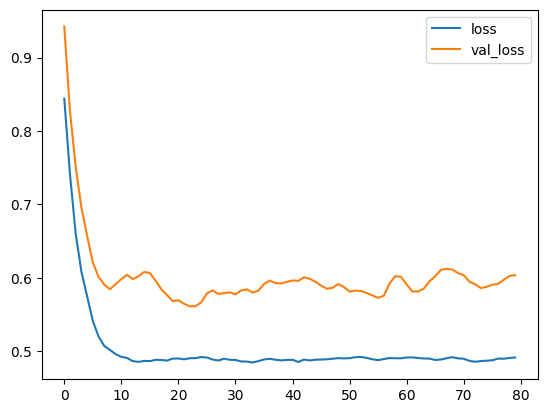

In [ ]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

13/13 [==============================] - 0s 2ms/step
(390, 1)


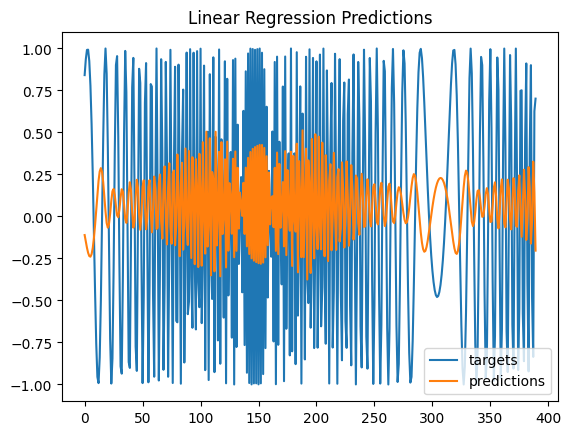

In [ ]:
# One-step forecast using true targets
# Note: even the one-step forecast fails badly
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title("Linear Regression Predictions")
plt.legend()
plt.show()

1/1 [==============================] - 0s 92ms/step


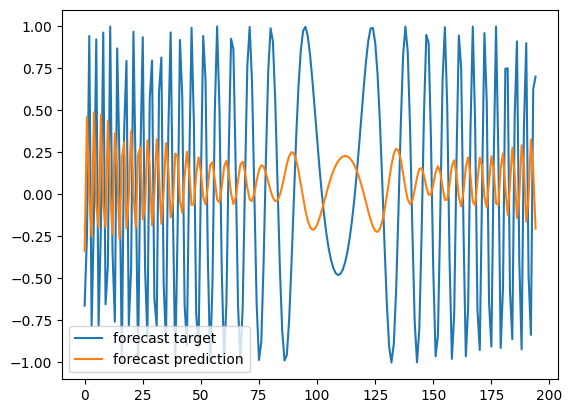

In [ ]:
# This is the code we had before - it does the same thing

# One-step forecast using true targets

validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = -N//2

while len(validation_predictions) < len(validation_target):
  p = model.predict(X[i].reshape(1, -1))[0,0] # 1x1 array -> scalar
  i += 1

  # update the predictions list
  validation_predictions.append(p)

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

1/1 [==============================] - 0s 23ms/step


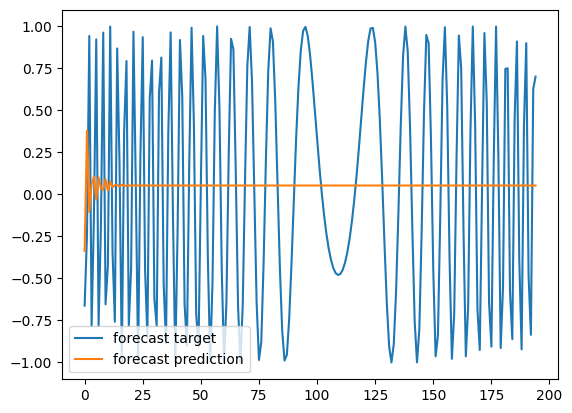

In [ ]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, -1))[0,0] # 1x1 array -> scalar

  # update the predictions list
  validation_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [ ]:
### Now try RNN/LSTM model
X = X.reshape(-1, T, 1) # make it N x T x D

# make the RNN
i = Input(shape=(T, D))
x = LSTM(10)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(learning_rate=0.05),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  batch_size=32,
  epochs=200,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/200
7/7 [==============================] - 4s 250ms/step - loss: 0.5195 - val_loss: 0.6096
Epoch 2/200
7/7 [==============================] - 0s 29ms/step - loss: 0.4952 - val_loss: 0.5864
Epoch 3/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5166 - val_loss: 0.5601
Epoch 4/200
7/7 [==============================] - 0s 32ms/step - loss: 0.4688 - val_loss: 0.5235
Epoch 5/200
7/7 [==============================] - 0s 15ms/step - loss: 0.4326 - val_loss: 0.4758
Epoch 6/200
7/7 [==============================] - 0s 15ms/step - loss: 0.4077 - val_loss: 0.4322
Epoch 7/200
7/7 [==============================] - 0s 15ms/step - loss: 0.2855 - val_loss: 0.3986
Epoch 8/200
7/7 [==============================] - 0s 15ms/step - loss: 0.1565 - val_loss: 0.2241
Epoch 9/200
7/7 [==============================] - 0s 14ms/step - loss: 0.0835 - val_loss: 0.2435
Epoch 10/200
7/7 [==============================] - 0s 14ms/step - loss: 0.0931 - val_loss: 0.1622
Epoch 11/200
7/7 [

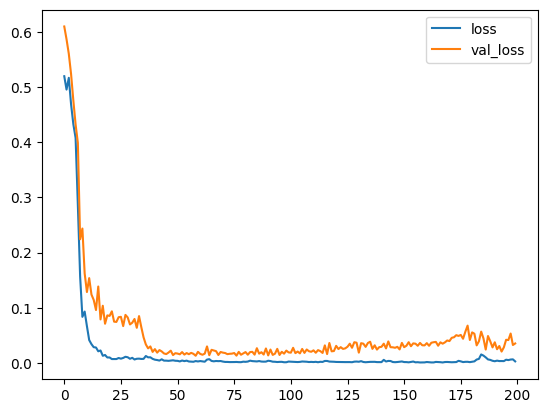

In [ ]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

13/13 [==============================] - 2s 6ms/step
(390, 1)


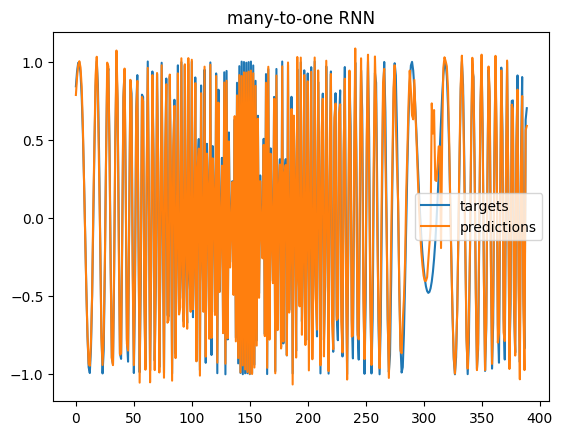

In [ ]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title("many-to-one RNN")
plt.legend()
plt.show()

1/1 [==============================] - 0s 26ms/step


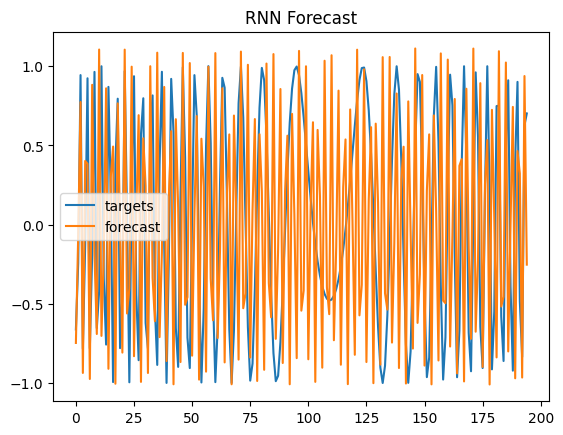

In [ ]:
# Multi-step forecast
forecast = []
input_ = X[-N//2]
while len(forecast) < len(Y[-N//2:]):
  # Reshape the input_ to N x T x D
  f = model.predict(input_.reshape(1, T, 1))[0,0]
  forecast.append(f)

  # make a new input with the latest forecast
  input_ = np.roll(input_, -1)
  input_[-1] = f

plt.plot(Y[-N//2:], label='targets')
plt.plot(forecast, label='forecast')
plt.title("RNN Forecast")
plt.legend()
plt.show()